### Trying different classifiers on data of KdV patients and ID controls
Overview of this notebook:

First the deepface representations of the cropped images are read in from an Excel file. The data is then plotted by using either t-sne or PCA for dimension reduction. It is clear that there aren't two clear clusters.

In the rest of the notebook the following classifiers are tested: k-NN, SVM, Random Forest, Gradient Boosting, AdaBoost, Gaussian Naive Bayes. In the end also an ensemble of all these methods or some of them is tried. None outperforming the Gradient Boosting classifier. 

To normalize the data either Normalizer (unit form) or StandardScaler (z = (x - mean)/std) is used, without any specific difference in performance yet.  

In [1]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
import itertools
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import date
from os.path import join 
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [2]:
def read_rep(kdv_csv, ID_csv):
    data = []
    labels = []

    for i, csv_file in enumerate([ID_csv, kdv_csv]):
        with open (csv_file, newline='') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                rep = list(map(float, row[1:]))
                data.append(rep)
                labels.append(i)
    
    return np.array(data), np.array(labels)

In [3]:
def plot_pca_tsne(data, labels, lowest_age = -1, highest_age = -1):
    plt.figure(figsize=(12,6))
    plt.plot([1,2])

    # visualize data in tnse (men/women)
    X_embedded_tsne = TSNE(n_components=2, init='pca').fit_transform(data)

    plt.subplot(121)
    unique = list(set(labels))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    for i, u in enumerate(unique):
        xi = [X_embedded_tsne[j, 0] for j  in range(len(X_embedded_tsne[:,0])) if labels[j] == u]
        yi = [X_embedded_tsne[j, 1] for j  in range(len(X_embedded_tsne[:,1])) if labels[j] == u]
        plt.scatter(xi, yi, c=[colors[i]], label=str(u))
    plt.legend()
    plt.title("t-sne for age range {}-{}".format(lowest_age, highest_age))

    # visualize data in pca (men/women)
    X_embedded_pca = PCA(n_components=2).fit_transform(data)

    plt.subplot(122)
    unique = list(set(labels))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    for i, u in enumerate(unique):
        xi = [X_embedded_pca[j, 0] for j  in range(len(X_embedded_pca[:,0])) if labels[j] == u]
        yi = [X_embedded_pca[j, 1] for j  in range(len(X_embedded_pca[:,1])) if labels[j] == u]
        plt.scatter(xi, yi, c=[colors[i]], label=str(u))
    plt.legend()
    plt.title("pca for age range{}-{}".format(lowest_age, highest_age))

    plt.show()

In [4]:
def plot_roc_curve(y_true, y_pred): 
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(1, figsize=(12,6))
    roc_auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label='LOOCV ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [5]:
def calculate_metrics_loo(model, data, labels):
    all_y, all_probs, all_preds = [], [], [] 
    loo = LeaveOneOut()
    
    for train, test in loo.split(data):
        all_y.append(labels[test])
        model = model.fit(data[train], labels[train])
        all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
        all_preds.append(model.predict(data[test].reshape(1, -1)))
        
    aroc = roc_auc_score(all_y, all_probs)
    tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn) 
    
    return aroc, spec, sens 

In [49]:
def normalize(data, i):

    if i == 0:
        return data
    
    if i == 1:
        return Normalizer().fit_transform(data)
        
    if i == 2:
        return StandardScaler().fit_transform(data)
        

### Method 3: Random Forest

In [69]:
def rf_classifier(data, labels):
    best_aroc = 0
    estimators = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    best_estimator_rf = 0
    best_norm = -1
    
    trees = 60

        
    data = Normalizer().fit_transform(data)

    # split train and test data
    print("Confusion matrix with 10% test data")
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
    print("Shape of train data: {} and shape of test data: {}".format(X_train.shape, X_test.shape))

    model = RandomForestClassifier(n_estimators=trees)
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

    # print("Tn: {}, fp: {}, fn: {}, tp: {}".format(tn, fp, fn , tp))
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn) 
    print("Specificity: {}".format(spec))
    print("Sensitivity: {}\n\n".format(sens))
    
    counter = 0
    loo = LeaveOneOut()

    all_y = [] # y_true
    all_preds = [] # y_pred
    for train, test in loo.split(data):
        all_y.append(labels[test])
        model = RandomForestClassifier(n_estimators=trees)

        model = model.fit(data[train], labels[train])
        all_preds.append(model.predict(data[test].reshape(1, -1)))
        counter+=1
        
    print("amount of leave one out: {}".format(counter))
    print("amount of samples: {}".format(data.shape))


    
    return best_estimator_rf, best_norm, best_aroc, best_spec, best_sens

In [70]:
def concatenate(data_df, labels_df, data_dlib, labels_dlib, data_combination, nr_feats):
    # assert data has same shape and labels are exactly the same
    assert data_df.shape[0] == data_dlib.shape[0]
    assert labels_df.shape == labels_dlib.shape
    match = [True for i, j in zip(labels_df, labels_dlib) if i == j]
    assert False not in match
                
                
    if data_combination == 2 or data_combination == 3 or data_combination == 4:
        # deepface + dlib (all features) 
        data, labels  = [], []
        for index, (df_i, dlib_i) in enumerate(zip(data_df, data_dlib)):
            if len(dlib_i) == 2210: 
                #only if a face is found (otherwise there a fewer zeros)
                data.append(df_i.tolist()+dlib_i) # concatenation of 4096 deepface + 2210 dlib
                labels.append(labels_df[index])
                
                                               
    if data_combination == 3:
        # deepface + dlib (x most important features)
        # data, labels are already filled from the above if statement
                                               
        # using a Random Forest the x most important features are used                                   
        forest = RandomForestClassifier(n_estimators=10,random_state=0) # 10 has been found with best aroc scores
        forest.fit(data, labels)
        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
        indices = np.argsort(importances)[::-1]
        indices = indices[0:nr_feats] # get 100 most important features

        data2 = []
        for row in data:
            data2.append(np.array(row)[indices])                                
        data = data2
   
    return 0, np.array(data), np.array(labels)
    

Shape of the data is: (144, 200)

Confusion matrix with 10% test data
Shape of train data: (129, 200) and shape of test data: (15, 200)


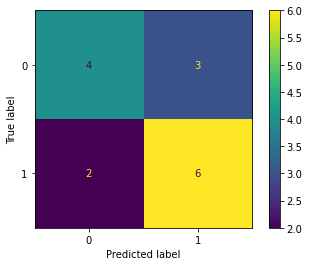

Specificity: 0.5714285714285714
Sensitivity: 0.75


amount of leave one out: 144
amount of samples: (144, 200)


NameError: name 'best_spec' is not defined

In [71]:
def main():    
    
    today = date.today()
    start = time.time()
    
    data_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv\representations\\"
    #results_file = open("results/kdv-results-" + str(today)+".txt", "w")

    nr_feats = 200
    
    ### NOTHING NEEDS TO BE EDITED BELOW ###
    
    for data_combination in [3]:
        
        #results_file.write(get_header(data_combination, nr_feats))
            
        age_ranges = [[1, 40]] # [[1, 3], [4, 16], [17, 40], [1, 40]] 

        for [low_age, high_age] in age_ranges:

            method = "dlib"
            kdv_csv = data_dir+"\kdv-patients-"+method+"-cropped-age-group-"+str(low_age)+"-"+str(high_age)+".csv"  
            ID_csv  = data_dir+"\ID-controls-"+method+"-cropped-age-group-"+str(low_age)+"-"+str(high_age)+".csv"
            data_dlib, labels_dlib = read_rep(kdv_csv, ID_csv)

            method = "deepface"
            kdv_csv = data_dir+"\kdv-patients-"+method+"-cropped-age-group-"+str(low_age)+"-"+str(high_age)+".csv"  
            ID_csv  = data_dir+"ID-controls-"+method+"-cropped-age-group-"+str(low_age)+"-"+str(high_age)+".csv"
            data_df, labels_df = read_rep(kdv_csv, ID_csv)

            
            # data, labels depend on data_combination
            nr_comps, data, labels = concatenate(data_df, labels_df, data_dlib, labels_dlib, data_combination, nr_feats)
            
            print("Shape of the data is: {}\n".format(data.shape))

            if data_combination == 4:
                results_file.write("Nr of pca components used: {}\n".format(nr_comps))


            # plot representation
            # plot_pca_tsne(data, labels, low_age, high_age)

            #results_file.write("CLASSIFIER RESULTS for kdv-control age group " + str(low_age) + "-" + str(high_age) + "\n")

            n_trees_rf, rf_norm, rf_aroc, rf_spec, rf_sens = rf_classifier(data, labels)
            break
            
            results_file.write("Random Forest classifier (trees = {}), normalize : {} \n    AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}\n".format(n_trees_rf, rf_norm, rf_aroc, rf_spec, rf_sens))

#             n_trees_gr, gr_norm, gr_aroc, gr_spec, gr_sens = gr_classifier(data, labels)
#             results_file.write("Gradient Boost classifier (trees = {}), normalize : {} \n    AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}\n".format(n_trees_gr, gr_norm, gr_aroc, gr_spec, gr_sens))

#             n_trees_ada, ada_norm, ada_aroc, ada_spec, ada_sens = ada_classifier(data, labels)
#             results_file.write("Ada Boost classifier (trees = {}), normalize : {} \n    AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}\n".format(n_trees_ada, ada_norm, ada_aroc, ada_spec, ada_sens))

            results_file.write("\n")

    end = time.time()
    results_file.write("Running this whole file took {} seconds".format(end-start))
    results_file.close()
    print("done running main file")
    
main()
    

### Method 7: VotingClassifier with GridSearch

https://www.kaggle.com/rmferg/soft-voting-classifier
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

import time
t0 = time.clock()

tree = DecisionTreeClassifier(random_state=1)
svm = SVC(probability=True, kernel='rbf')
knn = KNeighborsClassifier(p=2, metric='minkowski')
nb = GaussianNB()
eclf = VotingClassifier(estimators=[('tree', tree), ('svm', svm), ('knn', knn),('nb', nb)], voting='soft')

param_range10 = [.001, .01, 1, 10, 100]
param_range1 = list(range(3, 8))
param_grid = [{'svm__C':param_range10, 'svm__gamma':param_range10, 'tree__max_depth':param_range1, 
               'knn__n_neighbors':param_range1}]

gs = GridSearchCV(estimator=eclf, param_grid=param_grid, scoring='accuracy', cv=5)
gs = gs.fit(X_train_std, y_train)

print('Best accuracy score: %.3f \nBest parameters: %s' % (gs.best_score_, gs.best_params_))

clf = gs.best_estimator_
clf.fit(X_train_std, y_train)
t1 = time.clock()
print('Running time: %.3f' % (t1-t0))

from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test_std)
print('ROC AUC: %.3f \nAccuracy: %.3f \nConfusion Matrix:' % (roc_auc_score(y_true=y_test, y_score=y_pred),
                                         accuracy_score(y_true=y_test, y_pred=y_pred)))
print(confusion_matrix(y_true=y_test, y_pred=y_pred))